In [75]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import find_contours
import math
import scipy.spatial as spat
from shapely import MultiPoint, Polygon, LineString, Point
from shapely.ops import triangulate
import random
import time

In [165]:
# These functions are from the shared notebook

def plotpoly(poly, flag=True):
    fig, ax = plt.subplots()
    if flag:
      ax.plot(poly[:, 1], poly[:, 0], 'o-r', linewidth=2)
    else:
      ax.plot(poly[:, 0], poly[:, 1], 'o-r', linewidth=2)
      ax.plot([poly[-1, 0], poly[0, 0]], [poly[-1, 1], poly[0,1]], 'o-r', linewidth=2)
    return ax


def plotgraph(vertices, edges):
  x, y = [], []
  for v in vertices:
    x.append(v.x)
    y.append(v.y)
  plt.scatter(np.array(x), np.array(y))
  for e in edges:
    plt.plot([e.coords[0][0], e.coords[1][0]], [e.coords[0][1], e.coords[1][1]], 'm')


# This function is written by me to plot the shortest path in a graph

def plotPath(path, vertices, edges, src, dest):
    x, y = [], []
    for v in vertices:
        x.append(v.x)
        y.append(v.y)
    
    x = np.array(x)
    y = np.array(y)

    plt.scatter(x, y, color='purple')
    plt.scatter(x[src], y[src], color='green')
    plt.scatter(x[dest], y[dest], color='green')

    for e in edges:
        plt.plot([e.coords[0][0], e.coords[1][0]], [e.coords[0][1], e.coords[1][1]], 'r')
    for i in range(len(path)-1):
        plt.plot([vertices[path[i]].x, vertices[path[i+1]].x], [vertices[path[i]].y, vertices[path[i+1]].y], 'g')
    plt.show()


In [136]:
# This function is created by ChatGPT 4.0 I am using it only to create test graphs, not for the actual algorithm. 
# It creates half connected graphs. So the resulting graph is not connected, but pretty close to it.

def create_graph(vertex_count):
    vertices = []
    edges = []

    # Create vertices
    for i in range(vertex_count):
        x = random.randint(0, 100)
        y = random.randint(0, 100)
        vertices.append(Point(x, y))

    # Create edges
    for i in range(vertex_count):
        for j in range(i + 1, i + vertex_count // 3 + 1):
            if j < vertex_count:
                edges.append(LineString([vertices[i], vertices[j]]))

    return vertices, edges

def create_sparse_graph(vertex_count, connection_probability=0.15):
    vertices = []
    edges = []

    # Create vertices
    for i in range(vertex_count):
        x = random.randint(0, 100)
        y = random.randint(0, 100)
        vertices.append(Point(x, y))

    # Create edges with a given probability
    for i in range(vertex_count):
        for j in range(i + 1, vertex_count):
            if random.random() < connection_probability:
                edges.append(LineString([vertices[i], vertices[j]]))

    return vertices, edges


In [89]:
def findVertexbyCoord(coord, v):
    """
    Finds the index of a vertex in a list of vertices by its coordinates
    """
    for i in range(len(v)):
        if coord == tuple(v[i].coords[0]):
            return i
    return -1

def findNeighbours(v: list, e: list) -> dict:
    """
    Finds the neighbours of each vertex in a graph

    Parameters
    ----------
    v : list
        List of vertices
    e : list
        List of edges

    Returns
    -------
    dict
        Dictionary of neighbours for each vertex
    """
    neighours = {}

    for i in range(len(e)):
        v1 = findVertexbyCoord(e[i].coords[0], v)
        v2 = findVertexbyCoord(e[i].coords[1], v)
        if v1 not in neighours:
            neighours[v1] = []
        if v2 not in neighours:
            neighours[v2] = []
        neighours[v1].append(v2)
        neighours[v2].append(v1)
        

    return neighours


In [153]:
def findNextNode(to_visit, distance):
    """
    Finds the node with the smallest distance from the start node

    Parameters
    ----------
    to_visit : list
        List of nodes to visit
    distance : list
        List of distances from the start node to each node

    Returns
    -------
    int
        Index of the node with the smallest distance from the start node
    """
    minDistance = math.inf
    minIndex = -1
    for i,node in enumerate(to_visit):
        if distance[node] < minDistance:
            minDistance = distance[node]
            minIndex = i
    return minIndex

def shortestPathDijkstra(v : list,e : list, neighbours : dict, start :int, dest) -> list:
    """
    Finds the shortest path between two vertices in a graph using Dijkstra's algorithm

    Parameters
    ----------
    v : list
        List of vertices
    e : list
        List of edges
    start : int
        Index of the start vertex
    dest : int
        Index of the destination vertex

    Returns
    ------
    list
        List of vertices in the shortest path
    """
    # initialize the distance from the start node to all other nodes as infinity
    distance = [math.inf] * len(v)
    distance[start] = 0
    
    # initialize the list of visited nodes
    visited = []

    # initialize the list of nodes to visit
    to_visit = [start]

    # initialize the list of ancestors
    ancestors = [None] * len(v)

    while(to_visit):
        nextIndex = findNextNode(to_visit, distance)


        # get the node with the smallest distance from the start node
        current = to_visit.pop(nextIndex)
        current_v = v[current]
        visited.append(current)
        
        # get the neighbours of the current node
        if current not in neighbours: 
            continue

        current_neighbours = neighbours[current]


        # for each neighbour of the current node
        for neighbour in current_neighbours:
            # if the neighbour has not been visited
            if neighbour not in visited:
                
                neighbour_v = v[neighbour]

                calcDistance : float = current_v.distance(neighbour_v)
                

                # if the distance from the start node to the neighbour is shorter than the previously stored distance
                if distance[current] + calcDistance < distance[neighbour]:
                    # update the distance from the start node to the neighbour
                    distance[neighbour] = distance[current] + calcDistance
                    # update the ancestor of the neighbour
                    ancestors[neighbour] = current

                    # add the neighbour to the list of nodes to visit
                    to_visit.append(neighbour)

    path = []
    current = dest
    while current != start and current:
        path.append(current)
        current = ancestors[current]
        if current == None:
            return []
        
    path.append(start)
    path.reverse()

    return path

In [151]:
def weight(v1, v2):
    # return math.sqrt((v1.x - v2.x)**2 + (v1.y - v2.y)**2)
    return v1.distance(v2)

# Followed the pseudocode from the textbook
def shortestPathAStar(vertices, e, neighbours, src,dest):
    """
    Finds the shortest path between two vertices in a graph using A* algorithm

    Parameters
    ----------
    v : list
        List of vertices
    e : list
        List of edges
    src : int
        Index of the start vertex
    dest : int
        Index of the destination vertex

    Returns
    ------
    list
        List of vertices in the shortest path
    """
    S = set()
    distances_s = [math.inf] * len(vertices)

    distances_s[src] = 0

    pi = [None] * len(vertices)

    S.add(src)

    while S:
        v = -1
        
        tempDist = math.inf
        for i in S:
            if v == -1 or distances_s[v] + weight(vertices[i],vertices[dest]) < tempDist:
                v = i
        
        S.remove(v)

        if v == dest:
            break
        
        if v not in neighbours:
            continue
        for u in neighbours[v]:
            if pi[u] == None or (pi[u] and (u in S) and distances_s[u] > distances_s[v] + weight(vertices[v],vertices[u])):
                S.add(u)
                distances_s[u] = distances_s[v] + weight(vertices[v],vertices[u])
                pi[u] = v

    path = []
    while src != dest and dest != None:
        path.append(dest)
        dest = pi[dest]
        if dest == None:
            return []
    path.append(src)
    path.reverse()

    return path
            

In [112]:
graphSizes = list(range(10, 150))


graphs = [create_graph(size) for size in graphSizes]
print("done generating graphs")
NEIGHBOURS_STATIC = []
for i,(v,e) in enumerate(graphs):
    print(f"{i+1}/{len(graphs)}", end="\r")
    NEIGHBOURS_STATIC.append(findNeighbours(v,e))


done generating graphs


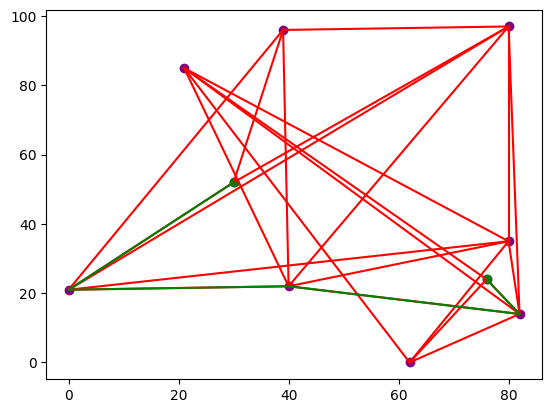

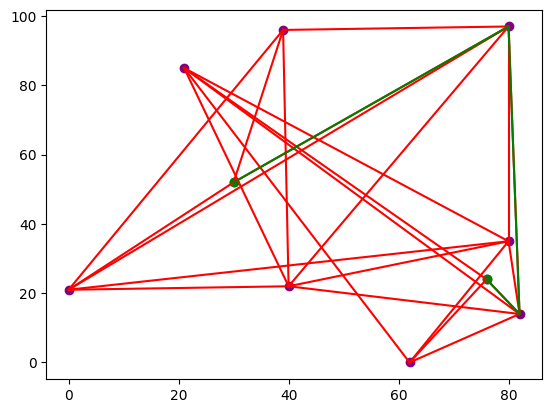

In [177]:
# Testing Dijkstra's algorithm

vertices, edges  = graphs[0]
neighbours = NEIGHBOURS_STATIC[0]

path = shortestPathDijkstra(vertices, edges, neighbours, 0, len(vertices)-1)

plotPath(path, vertices, edges, 0, len(vertices)-1)

# Testing A* algorithm

path = shortestPathAStar(vertices, edges, neighbours, 0, len(vertices)-1)

plotPath(path, vertices, edges, 0, len(vertices)-1)



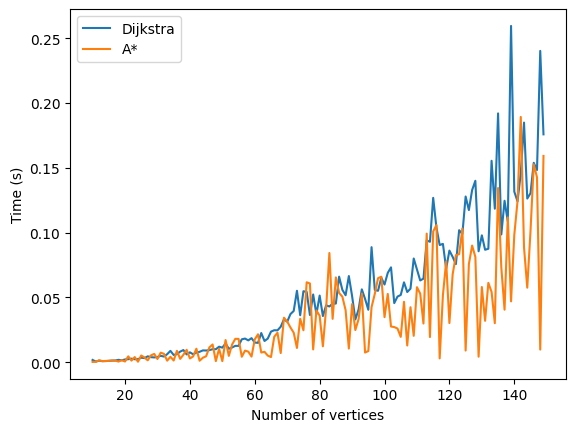

Average time for Dijkstra: 0.05313406160899571
Average time for A*: 0.034596129826136995


In [182]:
def race(graphs, NEIGHBOURS_STATIC, graphSizes, REPEAT=2):
    dijkstraTimes = []
    aStarTimes = []
    vertex_count = []

    for i in range(len(graphs)):
        vertices, edges = graphs[i]
        vertex_count.append(len(vertices))

        for j in range(REPEAT):
            src = random.randint(0,len(vertices)//2)
            dest = random.randint(len(vertices)//2, len(vertices)-1)

        
            start = time.time()
            shortestPathDijkstra(vertices, edges, NEIGHBOURS_STATIC[i], src, dest)
            end = time.time()

            dijkstraTimes.append(end - start)


            start = time.time()
            shortestPathAStar(vertices, edges, NEIGHBOURS_STATIC[i], src, dest)
            end = time.time()

            aStarTimes.append(end - start)

    xaxis = list(np.repeat(graphSizes, REPEAT))
    plt.plot(xaxis, dijkstraTimes, label="Dijkstra")
    plt.plot(xaxis, aStarTimes, label="A*")
    plt.xlabel("Number of vertices")
    plt.ylabel("Time (s)")
    plt.legend()
    plt.show()

    print(f"Average time for Dijkstra: {np.mean(dijkstraTimes)}")
    print(f"Average time for A*: {np.mean(aStarTimes)}")

race(graphs, NEIGHBOURS_STATIC, graphSizes,1)


In [119]:
import copy

store_n = copy.deepcopy(NEIGHBOURS_STATIC)
store_g = copy.deepcopy(graphs)

# Discussion

## Results

One of above cells, I am comparing the resulting paths of both algorithms. As you can see, they are different. It is because that the A* algorithm is converging to the shortest path, but not guaranteeing the path. On the contrary, dijkstra is guaranteed to find the shortest path available. So there cen be an expression like this

Shortest Path of Dijkstra <= Shortest Path of A*

## Benchmark Settings and Results


### Test Graphs

For the test graphs, I am using graph sizes of 10 to 150, so I have 150 different graphs. Each graph is pretty dense, more specifically every vertex is connected to the 1/3 of the total vertices. Spoiler alert, Dijkstra doesn't like this. 

### Settings

For the benchmark, I wanted to measure the pure performance of both algorithms, so none of the preinitialization steps is not included in the time measurement. For example, from the graphs I am creating, I am creating a neighbors dictionary for ease of use. This dictionary is created before the benchmark starts.

### Race

The time race's winner is of course A* algorithm. Although the Dijkstra's algorithm is more reliable because it gives the exact shortest path to the destination vertex, it is not making use of the assumptions. It is intelligent brute force. On the other hand, A* algorithm is trying to converging to the destination vertex, and it always checks if it is close enough to the destination vertex. This creates a chance of early exit. That why it is much and much faster than the Dijkstra's algorithm.

Note: It should be mentioned that the graph dataset favors the A* because the graphs are pretty dense. We would see much less difference if we had some sparse graphs. If there are many ways to go to the destination node from the source node, A* algorithm can find a pretty okay path before Dijkstra making it more optimized. That's why there is a huge difference.



# Bonus: Sparse Graphs

In [137]:
sparse_graphs = [create_sparse_graph(size) for size in graphSizes]
print("done generating graphs")
SPARSE_NEIGHBOURS_STATIC = []
for i,(v,e) in enumerate(sparse_graphs):
    print(f"{i+1}/{len(sparse_graphs)}", end="\r")
    SPARSE_NEIGHBOURS_STATIC.append(findNeighbours(v,e))


done generating graphs


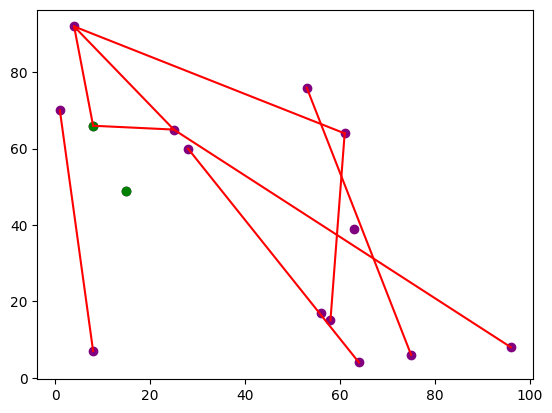

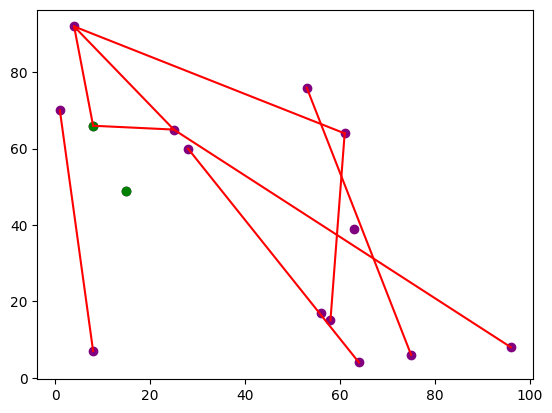

In [180]:
# Testing Dijkstra's algorithm

vertices, edges  = sparse_graphs[5]
neighbours = SPARSE_NEIGHBOURS_STATIC[5]

path = shortestPathDijkstra(vertices, edges, neighbours, 0, len(vertices)-1)
plotPath(path, vertices, edges, 0, len(vertices)-1)

# Testing A* algorithm

path = shortestPathAStar(vertices, edges, neighbours, 0, len(vertices)-1)
plotPath(path, vertices, edges,0, len(vertices)-1)



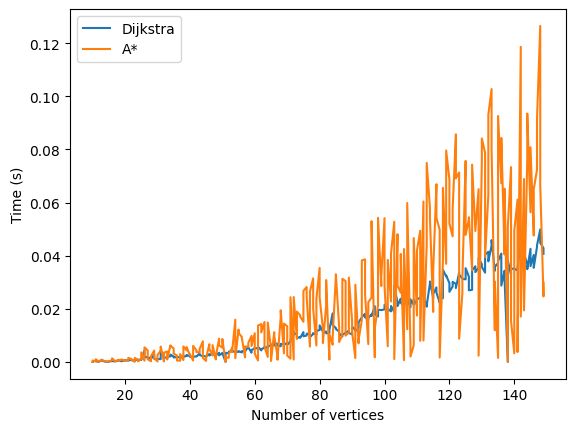

Average time for Dijkstra: 0.014888687644686018
Average time for A*: 0.02289121917315892


In [183]:
race(sparse_graphs, SPARSE_NEIGHBOURS_STATIC, graphSizes)

# Sparse Graph Discussion

As can be seen the time difference is not that much. A* is still trying to find the path optimized, but cannot reach many early exits. However, this is a very special case and dependent to the graph creation biases and selected source and destinations. So, still A* algorithm is better. 

Note: This difference exists because instead of using edges and their lengths, I am calculating the distance between vertexes again and again, so it slows down the A* for little cases a bit. Normally, they should work at the same time for even the worst case.